# 1. Исходные данные: преобразование датасета

1. Загрузка исходного видео/landmark-датасета.  

- информация о датасете: https://www.mdpi.com/2306-5729/6/4/38
- ссылка на датасет: https://zenodo.org/records/4537209


In [67]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import seaborn as sns
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import anderson
from typing import Tuple, Dict, Optional, List, Any
from tqdm import tqdm

In [ ]:
class_map = {
    1: "Ладонь к ладони",
    2: "Ладонь по тыльной стороне,\nпереплетённые пальцы",
    3: "Ладонь к ладони,\nпереплетённые пальцы",
    4: "Тыльные стороны пальцев\nк ладони, сцепленные пальцы",
    5: "Круговые движения\nбольшого пальца",
    6: "Подушечки пальцев\nпо ладони",
    7: "Выключение крана\nбумажным полотенцем",
    0: "Иное движение"
}

META_COLS = {
    "frame_idx",
    "frame_time",
    "movement_code",
    "is_washing",
    "dataset",
    "annotator",
    "video",
}

# 2. Предварительная обработка данных

0. Загрузка датасета в новом преобразованном формате parquet

In [ ]:
def _drop_empty_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Удаляет строки, где ВСЕ не-метаданные колонки содержат
    только NaN / None / 0 / 0.0
    """

    data_cols = [c for c in df.columns if c not in META_COLS]

    if not data_cols:
        return df

    def is_empty_row(row: pd.Series) -> bool:
        for val in row:
            # NaN / None
            if pd.isna(val):
                continue
            # числовой 0
            if isinstance(val, (int, float)) and val == 0:
                continue
            # если дошли сюда — есть полезные данные
            return False
        return True

    empty_mask = df[data_cols].apply(is_empty_row, axis=1)

    return df.loc[~empty_mask].reset_index(drop=True)


def _downcast_numeric_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Приводит числовые колонки DataFrame к 32-битным типам:
    - float64 -> float32
    - int64   -> int32

    Не трогает object, bool и category.
    """
    for col in df.columns:
        dtype = df[col].dtype

        if dtype == "float64":
            df[col] = df[col].astype("float32")

        elif dtype == "int64":
            df[col] = df[col].astype("int32")

    return df

In [5]:
def load_landmarks_dataset(
    root_dir: str,
    datasets: Optional[List[str]] = None,
    annotators: Optional[List[str]] = None,
    clean_empty: bool = True,
) -> pd.DataFrame:
    """
    Загружает все parquet-файлы с landmark-данными из структуры:
    """

    dfs: list[pd.DataFrame] = []

    for dataset_name in tqdm(os.listdir(root_dir), desc="Загрузка датасетов"):
        if datasets is not None and dataset_name not in datasets:
            continue

        dataset_path = os.path.join(root_dir, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        for annotator_name in os.listdir(dataset_path):
            if annotators is not None and annotator_name not in annotators:
                continue

            annotator_path = os.path.join(dataset_path, annotator_name)
            if not os.path.isdir(annotator_path):
                continue

            for fname in os.listdir(annotator_path):
                if not fname.endswith(".parquet"):
                    continue

                fpath = os.path.join(annotator_path, fname)

                # 1. Чтение parquet
                df = pd.read_parquet(fpath)

                # 2. Очистка пустых строк (если включено)
                if clean_empty:
                    df = _drop_empty_rows(df)

                # 3. Приведение типов к 32-битным
                df = _downcast_numeric_types(df)

                dfs.append(df)

    if not dfs:
        raise RuntimeError("Не найдено parquet-файлов")

    print(f"Загружено {len(dfs)} файлов с общим числом строк {sum(len(df) for df in dfs)}")
    print("Происходит конкатенация...")
    # 4. Конкатенация
    out_df = pd.concat(dfs, ignore_index=True)
    print("Готово")
    return out_df


In [ ]:
current_dir_code = os.getcwd()
dataset_folder_path = os.path.join(current_dir_code, "landmarks_parquet")

df_all = load_landmarks_dataset(dataset_folder_path, clean_empty=True)

Загрузка датасетов: 100%|██████████| 10/10 [09:54<00:00, 59.46s/it]


Загружено 5551 файлов с общим числом строк 3657028
Происходит конкатенация...
Готово


In [8]:
print("Сохранение неочещенного датасета...")
df_all.to_parquet("all_landmarks.parquet", index=False)
print("Датасет сохранен")

Сохранение неочещенного датасета...


In [3]:
print("Загрузка неочищенного датасета...")
df_all = pd.read_parquet("all_landmarks.parquet")
print("Датасет загружен")

Загрузка неочищенного датасета...
Датасет загружен


In [ ]:
# def collapse_annotations(df_all: pd.DataFrame) -> pd.DataFrame:
#     """
#     Схлопывает дублирующиеся аннотации от разных аннотаторов
#     согласно утверждённым правилам голосования.
#     """

#     required_cols = {
#         "dataset",
#         "video",
#         "frame_time",
#         "movement_code",
#         "annotator",
#     }
#     missing = required_cols - set(df_all.columns)
#     if missing:
#         raise ValueError(f"В df отсутствуют обязательные колонки: {missing}")

#     group_cols = ["dataset", "video", "frame_time"]

#     rows_out = []

#     for _, group in tqdm(df_all.groupby(group_cols, sort=False), desc="Удаление дубликатов аннотаций по группам"):

#         codes = group["movement_code"].values
#         unique_codes = np.unique(codes)

#         # ─────────────────────────────
#         # 1. Полное совпадение
#         # ─────────────────────────────
#         if len(unique_codes) == 1:
#             rows_out.append(group.iloc[0])
#             continue

#         # Подсчёт голосов
#         values, counts = np.unique(codes, return_counts=True)
#         vote_map = dict(zip(values, counts))

#         max_votes = counts.max()
#         majority_classes = values[counts == max_votes]

#         # ─────────────────────────────
#         # 2. Есть мажоритарный класс
#         # ─────────────────────────────
#         if len(majority_classes) == 1:
#             major = majority_classes[0]

#             # 2.1 Мажоритарный класс ≠ 0
#             if major != 0:
#                 rows_out.append(group[group["movement_code"] == major].iloc[0])
#                 continue

#             # 2.2 Мажоритарный класс == 0
#             non_zero = [c for c in unique_codes if c != 0]

#             # ровно один ненулевой
#             if len(non_zero) == 1:
#                 rows_out.append(group[group["movement_code"] == non_zero[0]].iloc[0])
#                 continue

#             # несколько ненулевых → удалить всё
#             continue

#         # ─────────────────────────────
#         # 3. Нет мажоритарного класса (ничья)
#         # ─────────────────────────────
#         non_zero = [c for c in unique_codes if c != 0]

#         # ровно {0, X}
#         if len(unique_codes) == 2 and 0 in unique_codes and len(non_zero) == 1:
#             rows_out.append(group[group["movement_code"] == non_zero[0]].iloc[0])
#             continue

#         # иначе — удалить всё
#         continue

#     if not rows_out:
#         return df_all.iloc[0:0].copy()

#     return pd.DataFrame(rows_out).reset_index(drop=True)

# df_collapsed = collapse_annotations(df_all)

Удаление дубликатов аннотаций по группам:  61%|██████    | 872162/1424499 [28:32<18:04, 509.25it/s]  


KeyboardInterrupt: 

Добавляем новый признак-флаг, указывающий на наличие данных для левой и правой руки

In [ ]:
# ~ инвертирует значения
df_all["L_present"] = (~df_all[[c for c in df_all.columns if c.startswith("L_x_")]].isna()).sum(axis=1) > 10
df_all["R_present"] = (~df_all[[c for c in df_all.columns if c.startswith("R_x_")]].isna()).sum(axis=1) > 10

C:\Users\magmy\AppData\Local\Temp\ipykernel_19924\753979743.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all["L_present"] = (~df_all[[c for c in df_all.columns if c.startswith("L_x_")]].isna()).sum(axis=1) > 10
C:\Users\magmy\AppData\Local\Temp\ipykernel_19924\753979743.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all["R_present"] = (~df_all[[c for c in df_all.columns if c.startswith("R_x_")]].isna()).sum(axis=1) > 10


Сохраняем данные

In [ ]:
clean_path = "landmarks_clean.parquet"
# df_all.to_parquet(clean_path, index=False)

In [ ]:
# df_all.to_csv("landmarks_clean_preview.csv", index=False)

Читаем данные

In [3]:
df_all = pd.read_parquet("landmarks_clean.parquet")

print(df_all.shape)
print(df_all.columns.tolist())
print(df_all.head())

(1397992, 329)
['frame_idx', 'frame_time', 'movement_code', 'is_washing', 'dataset', 'annotator', 'video', 'L_x_0', 'L_y_0', 'L_z_0', 'L_x_1', 'L_y_1', 'L_z_1', 'L_x_2', 'L_y_2', 'L_z_2', 'L_x_3', 'L_y_3', 'L_z_3', 'L_x_4', 'L_y_4', 'L_z_4', 'L_x_5', 'L_y_5', 'L_z_5', 'L_x_6', 'L_y_6', 'L_z_6', 'L_x_7', 'L_y_7', 'L_z_7', 'L_x_8', 'L_y_8', 'L_z_8', 'L_x_9', 'L_y_9', 'L_z_9', 'L_x_10', 'L_y_10', 'L_z_10', 'L_x_11', 'L_y_11', 'L_z_11', 'L_x_12', 'L_y_12', 'L_z_12', 'L_x_13', 'L_y_13', 'L_z_13', 'L_x_14', 'L_y_14', 'L_z_14', 'L_x_15', 'L_y_15', 'L_z_15', 'L_x_16', 'L_y_16', 'L_z_16', 'L_x_17', 'L_y_17', 'L_z_17', 'L_x_18', 'L_y_18', 'L_z_18', 'L_x_19', 'L_y_19', 'L_z_19', 'L_x_20', 'L_y_20', 'L_z_20', 'L_cx', 'L_cy', 'L_scale', 'L_nx_0', 'L_ny_0', 'L_nx_1', 'L_ny_1', 'L_nx_2', 'L_ny_2', 'L_nx_3', 'L_ny_3', 'L_nx_4', 'L_ny_4', 'L_nx_5', 'L_ny_5', 'L_nx_6', 'L_ny_6', 'L_nx_7', 'L_ny_7', 'L_nx_8', 'L_ny_8', 'L_nx_9', 'L_ny_9', 'L_nx_10', 'L_ny_10', 'L_nx_11', 'L_ny_11', 'L_nx_12', 'L_ny_12', 

Данные считаны, проведена первичная чистка пропусков в данных

1. Проверка и обработка пропусков. Удаление или интерполяция отсутствующих точек.

In [4]:
print("\nИнформация о типах данных и пропусках:")
print(df_all.info())

print("\nКоличество пропусков по каждому признаку:")
display(df_all.isnull().sum().sort_values(ascending=False)[:200])


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397992 entries, 0 to 1397991
Columns: 329 entries, frame_idx to R_present
dtypes: bool(2), float32(323), int32(1), object(3)
memory usage: 1.7+ GB
None

Количество пропусков по каждому признаку:


L_y_15    599540
L_z_15    599540
L_x_16    599540
L_z_13    599540
L_z_16    599540
           ...  
R_x_20    589994
R_z_19    589994
R_x_12    589994
R_z_12    589994
R_y_12    589994
Length: 200, dtype: int64

Достаточно большое количество пропусков (~0.6 млн) по сравнению с полученным датасетом (1.4 млн). Это нормально, поскольку в процесе мытья рук происходит переодическое перекрытие одной руки другой. Помимо этого, возможно сокрытие рук с камеры телом (врач наклонился и опустил руки в раковину) или руки закрывает моющий кран. Такие пропуски вырезать нельзя, поскольку это не ошибка и не шум. 

In [7]:
def clean_landmarks_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- 1. Определяем колонки признаков рук ----
    hand_cols = [c for c in df.columns if c not in META_COLS]

    if not hand_cols:
        raise ValueError("Не найдены признаки рук")

    # # ---- 2. Удаляем полностью пустые строки ----
    # # строка пустая, если ВСЕ признаки рук == NaN или 0
    # mask_non_empty = (
    #     df[hand_cols]
    #     .fillna(0)
    #     .abs()
    #     .sum(axis=1) > 0
    # )

    # df = df.loc[mask_non_empty].reset_index(drop=True)

    # ---- 4. Заполняем NaN / None нулями ----
    df[hand_cols] = df[hand_cols].fillna(0)

    # ---- 5. Приведение типов ----
    if "movement_code" in df:
        df["movement_code"] = df["movement_code"].astype(np.int32)

    if "is_washing" in df:
        df["is_washing"] = df["is_washing"].astype(np.int8)

    return df

df_all = clean_landmarks_dataframe(df_all)

In [8]:
print("\nИнформация о типах данных и пропусках:")
print(df_all.info())

print("\nКоличество пропусков по каждому признаку:")
display(df_all.isnull().sum().sort_values(ascending=False)[:200])


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397992 entries, 0 to 1397991
Columns: 329 entries, frame_idx to R_present
dtypes: bool(2), float32(321), int32(2), int8(1), object(3)
memory usage: 1.7+ GB
None

Количество пропусков по каждому признаку:


R_present        0
frame_idx        0
frame_time       0
movement_code    0
is_washing       0
                ..
R_y_15           0
R_z_15           0
R_x_16           0
R_y_16           0
R_z_16           0
Length: 200, dtype: int64

Пропусков больше нет

2. Описательная статистика:
    Среднее, медиана, std, min/max для координат и производных признаков.

In [9]:
print("\nСтатистические характеристики числовых признаков:")
display(df_all.describe())


Статистические характеристики числовых признаков:


,frame_idx,frame_time,movement_code,is_washing,L_x_0,L_y_0,L_z_0,L_x_1,L_y_1,L_z_1,...,R_nvx_16,R_nvy_16,R_nvx_17,R_nvy_17,R_nvx_18,R_nvy_18,R_nvx_19,R_nvy_19,R_nvx_20,R_nvy_20
count,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,...,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06
mean,7.763765e+02,2.589130e+04,1.689395e+00,9.056833e-01,1.182174e+02,6.982115e+01,3.596429e-08,1.181371e+02,7.108309e+01,-6.542044e-03,...,-2.671328e-03,2.258145e-03,-2.153350e-03,-1.355663e-05,-2.419880e-03,-2.853747e-03,-2.781497e-03,-7.310808e-04,-3.442001e-03,2.255440e-03
std,7.442457e+02,2.480566e+04,2.323629e+00,2.922689e-01,1.340981e+02,9.892671e+01,1.668774e-07,1.309755e+02,9.770535e+01,1.241341e-02,...,2.897560e+00,2.781452e+00,3.034393e+00,2.542150e+00,2.904579e+00,2.487334e+00,3.095301e+00,2.655676e+00,3.545919e+00,3.129710e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.425048e+02,-1.558120e+02,-2.594752e-06,-1.253337e+02,-1.065804e+02,-1.824611e-01,...,-4.576373e+01,-5.007626e+01,-5.479051e+01,-4.635031e+01,-5.443730e+01,-5.129211e+01,-5.612451e+01,-5.116145e+01,-5.775800e+01,-5.434524e+01
25%,2.610000e+02,8.733333e+03,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.163862e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.640000e+02,1.880000e+04,0.000000e+00,1.000000e+00,1.090373e+02,2.517969e+01,0.000000e+00,1.133581e+02,2.856816e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.062000e+03,3.540000e+04,3.000000e+00,1.000000e+00,1.781972e+02,1.060113e+02,1.088499e-07,1.784922e+02,1.111435e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.201000e+03,2.400333e+05,7.000000e+00,1.000000e+00,8.066085e+02,5.866859e+02,2.237789e-06,7.834637e+02,5.453035e+02,1.921641e-01,...,4.287004e+01,4.826408e+01,4.946070e+01,4.487297e+01,4.817575e+01,5.038107e+01,5.101270e+01,4.873883e+01,5.708481e+01,5.355266e+01


Вывод

3. Визуализация распределений с учетом шкал измерений:
    -	для дискретных значений (класс) – с помощью диаграмм частотности,
    -	для непрерывных – с помощью графиков функции плотности распределения.

Распределение классов в датасете

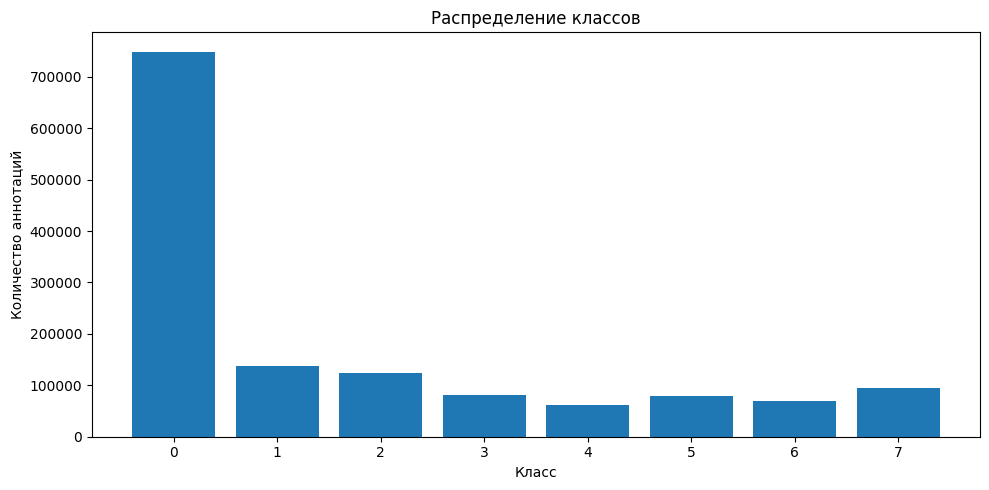

In [10]:
def plot_class_distribution(df, class_col="movement_code"):
    counts = df[class_col].value_counts().sort_index()

    plt.figure(figsize=(10, 5))
    plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel("Класс")
    plt.ylabel("Количество аннотаций")
    plt.title("Распределение классов")
    plt.tight_layout()
    plt.show()

plot_class_distribution(df_all)

Наблюдается дисбаланс классов, нужно почистить всю пустую информацию из класса 0 (вырезаются сегменты с длительным обозначением класса 0 (сегменты больше 11 кадров))

Удаление длинных сегментов класса 0: 100%|██████████| 2475/2475 [00:11<00:00, 216.66it/s]


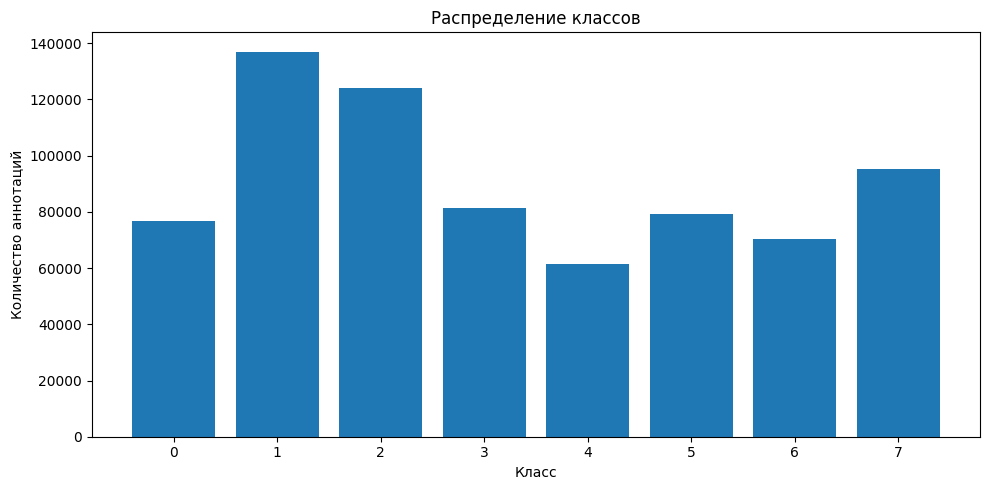

In [12]:
def drop_long_zero_segments(
    df: pd.DataFrame,
    zero_class: int = 0,
    keep_edge: int = 5,
    group_cols: list[str] = ["dataset", "video"],
    time_col: str = "frame_idx",
) -> pd.DataFrame:
    """
    Удаляет середину длинных сегментов movement_code == zero_class.
    
    Правило:
    - если длина сегмента < 2*keep_edge + 1 → оставляем всё
    - иначе → оставляем первые keep_edge и последние keep_edge
    
    Основание: борьба с дисбалансом класса 0 без потери динамики.
    """

    kept_indices = []

    # обрабатываем каждое видео отдельно
    for _, g in tqdm(df.groupby(group_cols), desc="Удаление длинных сегментов класса 0"):
        g = g.sort_values(time_col)

        codes = g["movement_code"].values
        idxs = g.index.values

        start = 0
        n = len(codes)

        while start < n:
            if codes[start] != zero_class:
                kept_indices.append(idxs[start])
                start += 1
                continue

            # нашли начало zero-сегмента
            end = start
            while end < n and codes[end] == zero_class:
                end += 1

            seg_len = end - start

            if seg_len < 2 * keep_edge + 1:
                # короткий сегмент — оставляем всё
                kept_indices.extend(idxs[start:end])
            else:
                # длинный сегмент — режем середину
                kept_indices.extend(idxs[start:start + keep_edge])
                kept_indices.extend(idxs[end - keep_edge:end])

            start = end

    kept_indices = sorted(set(kept_indices))
    return df.loc[kept_indices].reset_index(drop=True)

df_all = drop_long_zero_segments(df_all)
plot_class_distribution(df_all)

Классы +- сбалансированы, сохраняем

In [ ]:
df_all.to_parquet("landmarks_clean_and_balanced.parquet", index=False)

In [ ]:
print("Загрузка данных")
df_all = pd.read_parquet("landmarks_clean_and_balanced.parquet")
print("Готово")

Загрузка данных
Готово


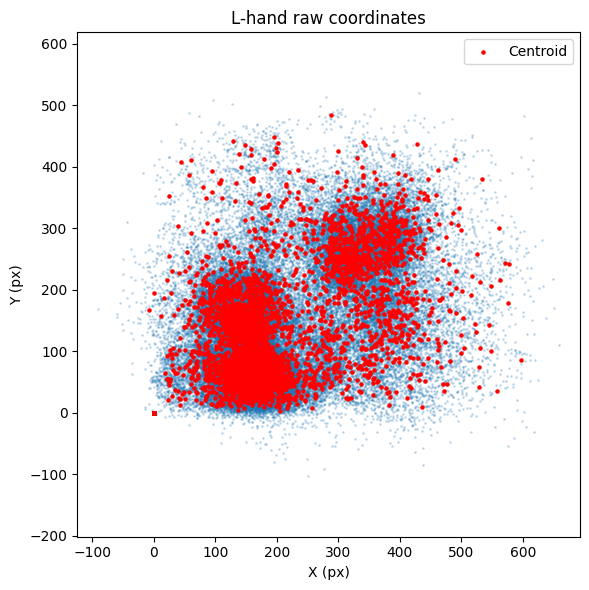

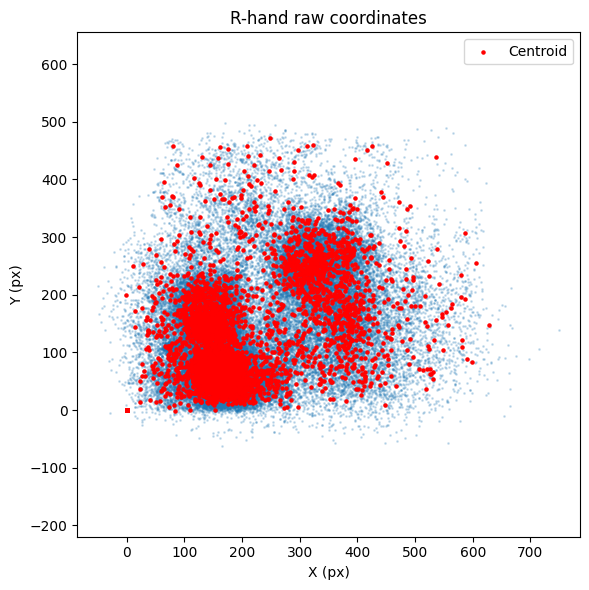

In [13]:
def plot_raw_hand_coordinates(df, hand="L", sample=20000):
    # Распределение сырых координат рук с центроидами

    x_cols = [c for c in df.columns if c.startswith(f"{hand}_x_")]
    y_cols = [c for c in df.columns if c.startswith(f"{hand}_y_")]

    cx_col = f"{hand}_cx"
    cy_col = f"{hand}_cy"

    # подвыборка (иначе слишком тяжело)
    df_s = df.sample(min(sample, len(df)), random_state=42)

    xs = df_s[x_cols].values.flatten()
    ys = df_s[y_cols].values.flatten()

    xs = xs[~np.isnan(xs)]
    ys = ys[~np.isnan(ys)]

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=1, alpha=0.2)
    plt.scatter(df_s[cx_col], df_s[cy_col], c="red", s=5, label="Centroid")

    plt.xlabel("X (px)")
    plt.ylabel("Y (px)")
    plt.title(f"{hand}-hand raw coordinates")
    plt.legend()
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

plot_raw_hand_coordinates(df_all, hand="L", sample=10000)
plot_raw_hand_coordinates(df_all, hand="R", sample=10000)

Сырые данные координат ключевых точек рук интересно сгрупированы... 

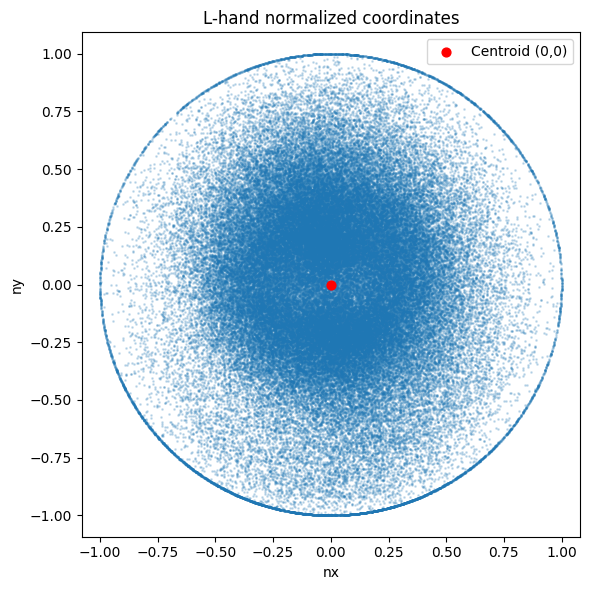

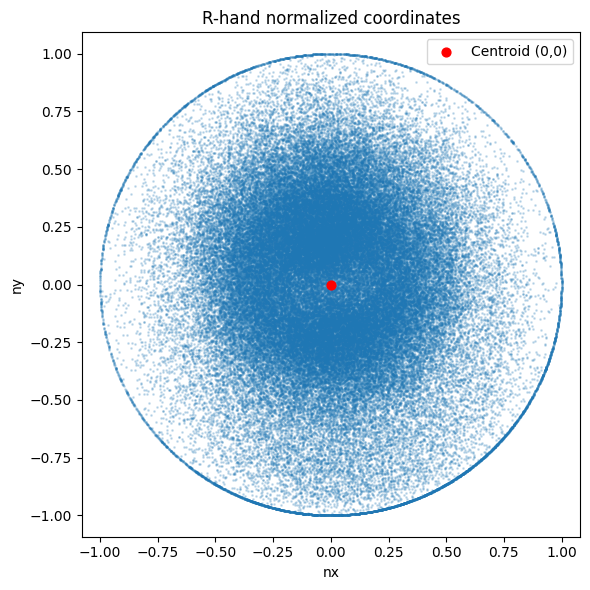

In [14]:
def plot_normalized_hand_coordinates(df, hand="L", sample=20000):
    # Рспределение нормализованных координат руки с центроидом в (0,0)

    x_cols = [c for c in df.columns if c.startswith(f"{hand}_nx_")]
    y_cols = [c for c in df.columns if c.startswith(f"{hand}_ny_")]

    df_s = df.sample(min(sample, len(df)), random_state=42)

    xs = df_s[x_cols].values.flatten()
    ys = df_s[y_cols].values.flatten()

    xs = xs[~np.isnan(xs)]
    ys = ys[~np.isnan(ys)]

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=1, alpha=0.2)
    plt.scatter(0, 0, c="red", s=40, label="Centroid (0,0)")

    plt.xlabel("nx")
    plt.ylabel("ny")
    plt.title(f"{hand}-hand normalized coordinates")
    plt.legend()
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


plot_normalized_hand_coordinates(df_all, hand="L", sample=10000)
plot_normalized_hand_coordinates(df_all, hand="R", sample=10000)

еще интереснее

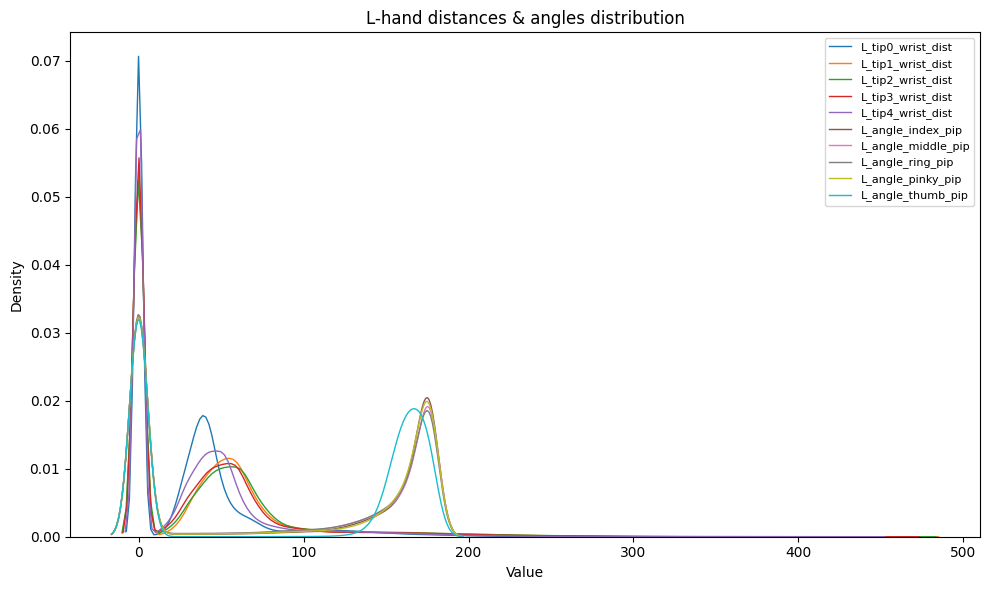

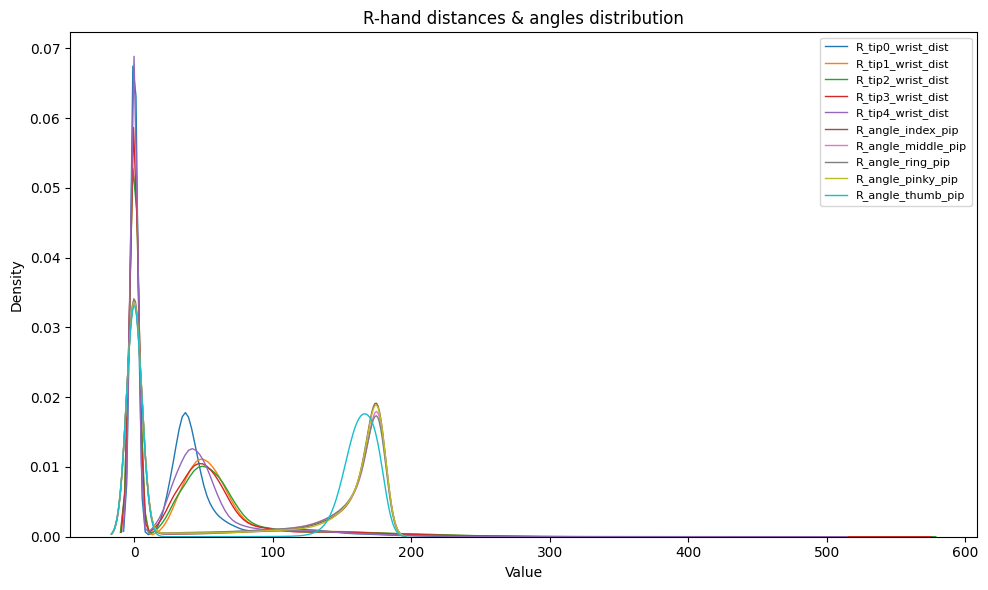

In [15]:
def plot_distances_and_angles(df, hand="L"):
    # Распределение расстояний и углов пальцев для указанной руки

    cols = [
        f"{hand}_tip0_wrist_dist",
        f"{hand}_tip1_wrist_dist",
        f"{hand}_tip2_wrist_dist",
        f"{hand}_tip3_wrist_dist",
        f"{hand}_tip4_wrist_dist",
        f"{hand}_angle_index_pip",
        f"{hand}_angle_middle_pip",
        f"{hand}_angle_ring_pip",
        f"{hand}_angle_pinky_pip",
        f"{hand}_angle_thumb_pip",
    ]

    plt.figure(figsize=(10, 6))

    for c in cols:
        if c in df:
            sns.kdeplot(df[c], label=c, linewidth=1)

    plt.title(f"{hand}-hand distances & angles distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

plot_distances_and_angles(df_all, hand="L")
plot_distances_and_angles(df_all, hand="R")

Вывод

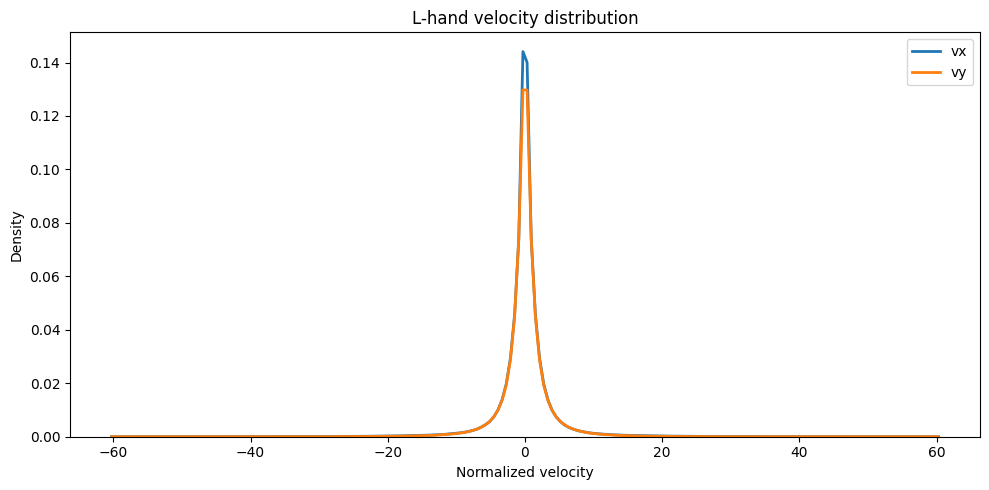

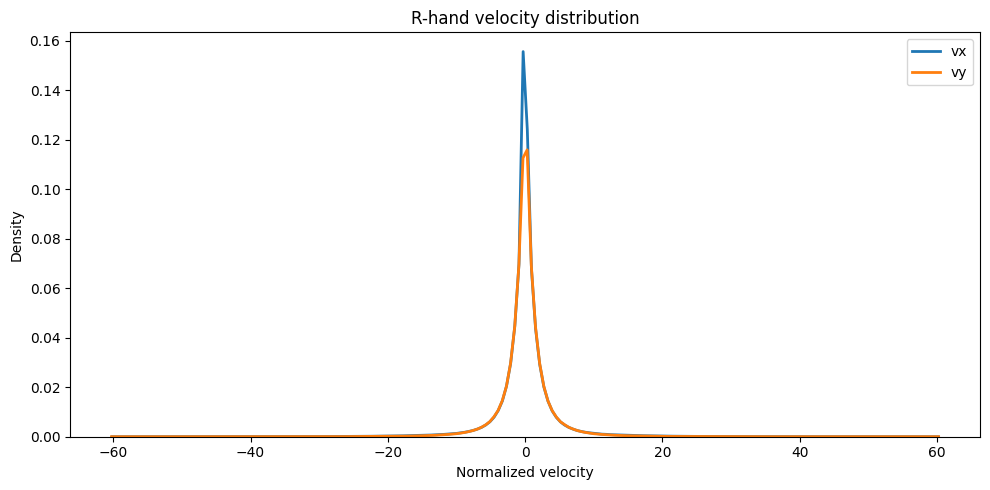

In [19]:
def plot_velocity_distribution(df, hand="L"):
    # Распределения скоростей (производные)

    vx_cols = [c for c in df.columns if c.startswith(f"{hand}_nvx_")]
    vy_cols = [c for c in df.columns if c.startswith(f"{hand}_nvy_")]

    vx = df[vx_cols].values.flatten()
    vy = df[vy_cols].values.flatten()

    vx = vx[~np.isnan(vx)]
    vy = vy[~np.isnan(vy)]

    plt.figure(figsize=(10, 5))
    sns.kdeplot(vx, label="vx", linewidth=2)
    sns.kdeplot(vy, label="vy", linewidth=2)

    plt.title(f"{hand}-hand velocity distribution")
    plt.xlabel("Normalized velocity")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_velocity_distribution(df_all, hand="L")
plot_velocity_distribution(df_all, hand="R")

Вывод

4. Проверка гипотез:
    - нормальное (логнормальное) распределение непрерывных признаков (Shapiro–Wilk..).
    - Корреляция или независимость между признаками (Pearson/Spearman).

Shapiro–Wilk становится чувствительным при n > 5000, поэтому используем anderson

In [ ]:
continuous_features = {
    # расстояния
    "L_tip_dist": [
        "L_tip0_wrist_dist",
        "L_tip1_wrist_dist",
        "L_tip2_wrist_dist",
        "L_tip3_wrist_dist",
        "L_tip4_wrist_dist",
    ],
    "R_tip_dist": [
        "R_tip0_wrist_dist",
        "R_tip1_wrist_dist",
        "R_tip2_wrist_dist",
        "R_tip3_wrist_dist",
        "R_tip4_wrist_dist",
    ],

    # углы
    "L_angles": [
        "L_angle_index_pip",
        "L_angle_middle_pip",
        "L_angle_ring_pip",
        "L_angle_pinky_pip",
        "L_angle_thumb_pip",
    ],
    "R_angles": [
        "R_angle_index_pip",
        "R_angle_middle_pip",
        "R_angle_ring_pip",
        "R_angle_pinky_pip",
        "R_angle_thumb_pip",
    ],

    # скорости 
    "L_velocity": ["L_nvx_0", "L_nvy_0", "L_nvx_8", "L_nvy_8"],
    "R_velocity": ["R_nvx_0", "R_nvy_0", "R_nvx_8", "R_nvy_8"],
}

In [15]:
def anderson_normality_test(
    df: pd.DataFrame,
    features: dict[str, list[str]],
) -> pd.DataFrame:

    results = []

    for group_name, cols in features.items():
        for col in cols:
            if col not in df.columns:
                continue

            data = df[col].dropna()
            if len(data) < 100:
                continue  # слишком мало данных

            try:
                stat = anderson(data)

                crit_05 = stat.critical_values[2]  # уровень 5%
                conclusion = "Нормальное" if stat.statistic < crit_05 else "Не нормальное"

                results.append({
                    "Группа": group_name,
                    "Признак": col,
                    "A2": round(stat.statistic, 3),
                    "Критическое (5%)": round(crit_05, 3),
                    "Вывод": conclusion,
                })

            except Exception as e:
                results.append({
                    "Группа": group_name,
                    "Признак": col,
                    "Ошибка": str(e),
                })

    return pd.DataFrame(results)


In [16]:
anderson_df = anderson_normality_test(
    df_all,
    continuous_features
)

display(anderson_df)


,Группа,Признак,A2,Критическое (5%),Вывод
0,L_tip_dist,L_tip0_wrist_dist,47575.904,0.787,Не нормальное
1,L_tip_dist,L_tip1_wrist_dist,46430.798,0.787,Не нормальное
2,L_tip_dist,L_tip2_wrist_dist,46836.027,0.787,Не нормальное
3,L_tip_dist,L_tip3_wrist_dist,46556.337,0.787,Не нормальное
4,L_tip_dist,L_tip4_wrist_dist,45466.746,0.787,Не нормальное
5,R_tip_dist,R_tip0_wrist_dist,52811.623,0.787,Не нормальное
6,R_tip_dist,R_tip1_wrist_dist,50187.341,0.787,Не нормальное
7,R_tip_dist,R_tip2_wrist_dist,50174.120,0.787,Не нормальное
8,R_tip_dist,R_tip3_wrist_dist,49776.636,0.787,Не нормальное
9,R_tip_dist,R_tip4_wrist_dist,48632.062,0.787,Не нормальное


Проверка гипотез о нормальности распределений непрерывных признаков показала, что ни один из исследуемых признаков (расстояния, углы и компоненты скоростей как для левой, так и для правой руки) не подчиняется нормальному или логнормальному распределению на уровне значимости 5%. Для всех признаков значение статистики Андерсона-Дарлинга многократно превышает критическое значение, что свидетельствует о существенном отклонении эмпирических распределений от теоретических. Это ожидаемо для кинематических признаков жестов, характеризующихся асимметрией, многомодальностью и зависимостью от фаз движения, и обосновывает использование непараметрических методов анализа, в частности корреляции Спирмена, а также моделей машинного обучения, не предполагающих нормальность входных данных.

Проверяем линейную и монотонную зависимость

In [ ]:
def plot_corr_heatmap(corr: pd.DataFrame, title: str):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.7},
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

# собираем список признаков для корреляции
corr_features = []

for cols in continuous_features.values():
    corr_features.extend(cols)

corr_features += ["L_present", "R_present"]

corr_features = [c for c in corr_features if c in df_all.columns]

df_corr = df_all[corr_features]

pearson_corr = df_corr.corr(method="pearson")
spearman_corr = df_corr.corr(method="spearman")


In [40]:
spearman_corr.to_csv("spearman_corr.csv", index=False)

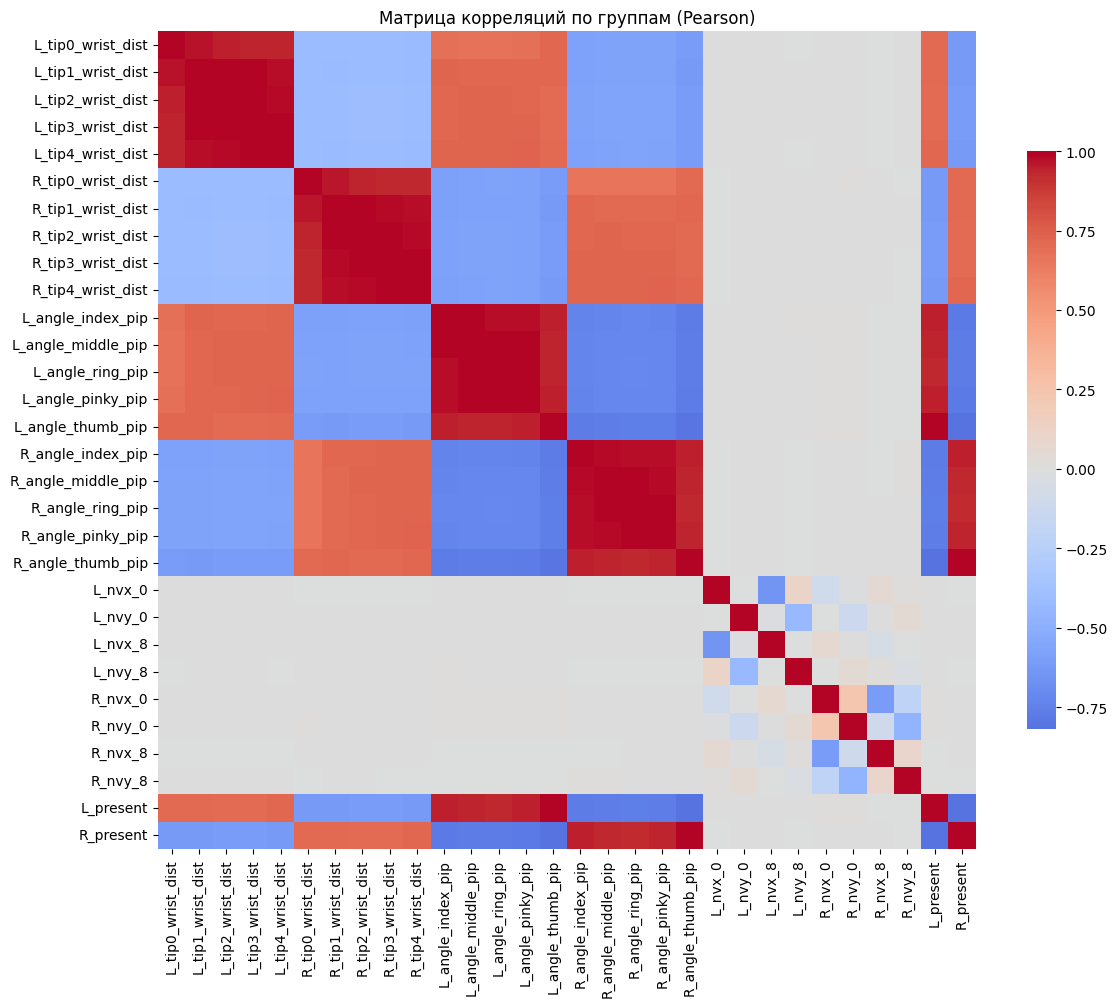

In [30]:
plot_corr_heatmap(
    pearson_corr,
    "Матрица корреляций по группам (Pearson)"
)

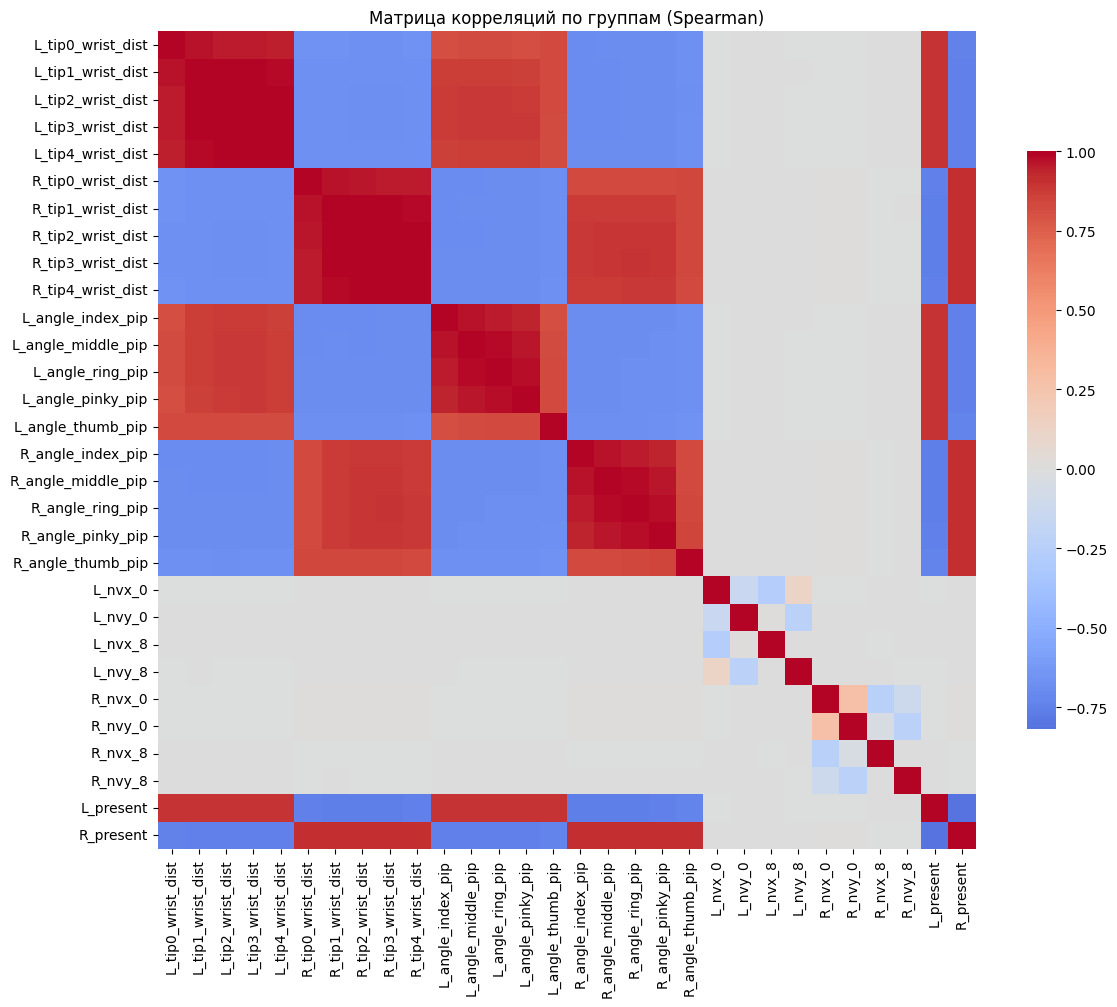

In [31]:
plot_corr_heatmap(
    spearman_corr,
    "Матрица корреляций по группам (Spearman)"
)

В датасете наблюдается выраженная мультиколлинеарность внутри однородных групп признаков. Расстояния от кончиков пальцев до запястья внутри одной руки сильно положительно коррелируют между собой (ρ ≈ 0.95–0.99), что указывает на избыточность этих признаков. Аналогично, углы в PIP-суставах пальцев внутри одной руки также демонстрируют высокую взаимную корреляцию (ρ ≈ 0.94–0.98). Между признаками левой и правой руки фиксируется устойчивая отрицательная корреляция для расстояний и углов, что отражает компенсаторную или асимметричную работу рук при выполнении движений. Скоростные признаки (nvx, nvy) практически некоррелированы с геометрическими характеристиками (|ρ| ≈ 0), что говорит об их независимом информационном вкладе. Бинарные признаки L_present и R_present сильно коррелируют с соответствующими геометрическими группами, что ожидаемо и подтверждает корректность их семантики. В целом данные содержат значительное количество коррелированных признаков, поэтому для линейных моделей желательно учитывать регуляризацию или снижение размерности, тогда как для деревьев и ансамблей данная структура не является критичной.

- Углы
Наблюдение:
Корреляция между углами пальцев внутри руки ≈ 0.94–0.98.

Интерпретация:
Пальцы часто сгибаются согласованно, углы дублируют друг друга.

- Скорости
Наблюдение:
Между разными точками корреляция умеренная или слабая.

С геометрией почти не коррелируют.

Интерпретация:
Скорость — отдельный, полезный источник информации (динамика).

- Координаты
Решение:

Оставлять только одну форму (обычно нормализованную).

Абсолютные координаты отсекаются, если есть центрированные/масштабированные аналоги.

5. Нормализация признаков:
    - Центрирование относительно centroid. (Проведено на стадии преобразования формата датасета)
    - Масштабирование признаков (StandardScaler или MinMaxScaler).

MinMaxScaler чувствителен к выбросам, будем использовать StandardScaler

Масштабирование признаков необходимо для моделей, чувствительных к масштабу входных данных, таких как логистическая регрессия и SVM. В датасете жестов масштабированию подлежат все непрерывные кинематические признаки — координаты, скорости, расстояния и углы, тогда как бинарные индикаторы присутствия руки и служебные временные признаки масштабированию не подвергаются. В качестве метода масштабирования выбран StandardScaler, так как он устойчив к выбросам и не требует предположения о нормальности распределений.

In [48]:
TARGET_COL = "movement_code"

META_COLS = [
    "dataset",
    "video",
    "frame_idx",
    "frame_time",
    "annotator",
]

BINARY_COLS = [
    "L_present",
    "R_present",
    "is_washing",
]


In [39]:
# Получение списка колонок-признаков (без метаданных и целевой)
def get_feature_columns(df: pd.DataFrame) -> list[str]:
    exclude = set(META_COLS + [TARGET_COL])
    return [c for c in df.columns if c not in exclude]

# Для дереьев решений не масштабируем признаки
def prepare_tree_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    features = get_feature_columns(df)

    df_tree = df[features + [TARGET_COL]].copy()

    return df_tree

# Масштабируем признаки для моделей, чувствительных к масштабу
def prepare_scaled_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame, StandardScaler]:
    features = get_feature_columns(df)

    # признаки, которые масштабируем
    scale_cols = [c for c in features if c not in BINARY_COLS]

    df_scaled = df[features + [TARGET_COL]].copy()

    scaler = StandardScaler()
    df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])

    return df_scaled, scaler

df_tree = prepare_tree_dataframe(df_all)

df_scaled, scaler = prepare_scaled_dataframe(df_all)
display(df_scaled.describe().round(3))

,is_washing,L_x_0,L_y_0,L_z_0,L_x_1,L_y_1,L_z_1,L_x_2,L_y_2,L_z_2,...,R_nvy_16,R_nvx_17,R_nvy_17,R_nvx_18,R_nvy_18,R_nvx_19,R_nvy_19,R_nvx_20,R_nvy_20,movement_code
count,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,...,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000
mean,0.950,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,...,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,3.255
std,0.219,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.304
min,0.000,-1.732,-2.288,-15.797,-1.515,-1.808,-14.556,-1.321,-1.383,-15.724,...,-17.646,-17.669,-18.984,-18.583,-18.509,-17.465,-18.470,-15.501,-17.182,0.000
25%,1.000,-0.876,-0.641,-0.374,-0.895,-0.662,-0.421,-0.910,-0.705,-0.417,...,0.002,0.000,-0.003,0.000,-0.001,-0.000,0.000,-0.000,0.000,1.000
50%,1.000,0.004,-0.455,-0.374,0.035,-0.449,0.541,0.047,-0.414,0.544,...,0.002,0.000,-0.003,0.000,-0.001,-0.000,0.000,-0.000,0.000,3.000
75%,1.000,0.495,0.048,0.527,0.510,0.107,0.541,0.530,0.214,0.544,...,0.002,0.000,-0.003,0.000,-0.001,-0.000,0.000,-0.000,0.000,5.000
max,1.000,4.977,5.558,12.928,4.762,5.200,13.032,4.782,5.000,13.567,...,17.459,14.486,18.374,15.849,20.262,15.874,18.077,15.071,16.946,7.000


Вывод

6. Снижение размерности:
    - PCA/tSNE (построить график)
    - Проверить возможность понижения размерности за счет выбора наиболее информативных признаков (часть признаков отсекаем, часть оставляем). 

PCA теряет физический смысл признаков — можно использовать для анализа и аргументации, t-SNE — только для графиков. Основное снижение размерности лучше делать через отбор признаков, а не через проекцию.

Анализ корреляций показал выраженную мультиколлинеарность внутри групп геометрических признаков одной руки. В целях снижения размерности и предотвращения избыточности признакового пространства была применена фильтрация высоко коррелированных признаков, при которой сохранялись репрезентативные или агрегированные характеристики, а дублирующие признаки исключались. Такой подход позволил сократить размерность данных без существенной потери информативности и повысить устойчивость моделей машинного обучения.

Итог: что именно отсекается

Рекомендуется удалить:

- избыточные tip*_wrist_dist (оставить 1–2 на руку);

- избыточные angle_*_pip (оставить 1 или агрегат);

- nvx/nvy для большинства landmark’ов, кроме ключевых;

- дублирующие координатные представления;

- любые признаки с корреляцией |ρ| > 0.95 внутри одной семантической группы.

Оставляется:

- компактный набор геометрии,

- динамика (скорости),

- индикаторы присутствия рук,

- целевая переменная.

In [41]:
def drop_correlated_features(
    df: pd.DataFrame,
    target_col: str = "movement_code",
    always_keep: list[str] | None = None,
    corr_threshold: float = 0.95,
) -> pd.DataFrame:
    """
    Удаляет избыточные признаки на основе корреляции.
    """

    if always_keep is None:
        always_keep = []

    # Берём только числовые признаки
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Исключаем таргет
    num_cols = [c for c in num_cols if c != target_col]

    corr = df[num_cols].corr().abs()

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = set()
    for col in upper.columns:
        high_corr = upper[col][upper[col] > corr_threshold].index.tolist()
        for hc in high_corr:
            if hc not in always_keep:
                to_drop.add(hc)

    print(f"Удалено признаков из-за корреляции > {corr_threshold}: {len(to_drop)}")

    keep_cols = [
        c for c in df.columns
        if c not in to_drop
    ]

    return df[keep_cols]


always_keep = [
    "movement_code",
    "L_present",
    "R_present",
]

df_reduced = drop_correlated_features(
    df_all,
    always_keep=always_keep,
)

print("Размерность до:", df_all.shape)
print("Размерность после:", df_reduced.shape)


Удалено признаков из-за корреляции > 0.95: 161
Размерность до: (725647, 329)
Размерность после: (725647, 168)


In [43]:
df_tree = prepare_tree_dataframe(df_reduced)

df_scaled, scaler = prepare_scaled_dataframe(df_reduced)
display(df_scaled.describe().round(3))

,is_washing,L_z_0,L_z_4,L_z_20,L_cx,L_cy,L_nx_0,L_nx_1,L_nx_2,L_nx_3,...,R_nvx_16,R_nvy_16,R_nvx_17,R_nvy_17,R_nvx_18,R_nvy_18,R_nvy_19,R_nvx_20,R_nvy_20,movement_code
count,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,...,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000,725647.000
mean,0.950,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,...,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,3.255
std,0.219,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.304
min,0.000,-15.797,-20.058,-18.679,-1.110,-1.110,-2.282,-3.220,-4.062,-3.983,...,-15.189,-17.646,-17.669,-18.984,-18.583,-18.509,-18.470,-15.501,-17.182,0.000
25%,1.000,-0.374,-0.406,-0.477,-0.920,-0.794,-0.256,-0.173,-0.130,-0.090,...,-0.000,0.002,0.000,-0.003,0.000,-0.001,0.000,-0.000,0.000,1.000
50%,1.000,-0.374,0.540,0.405,0.100,-0.256,0.041,0.012,-0.040,-0.077,...,-0.000,0.002,0.000,-0.003,0.000,-0.001,0.000,-0.000,0.000,3.000
75%,1.000,0.527,0.540,0.405,0.526,0.379,0.218,0.204,0.251,0.258,...,-0.000,0.002,0.000,-0.003,0.000,-0.001,0.000,-0.000,0.000,5.000
max,1.000,12.928,15.424,15.063,4.569,5.011,2.364,3.243,3.981,3.829,...,14.123,17.459,14.486,18.374,15.849,20.262,18.077,15.071,16.946,7.000


Удалено признаков из-за корреляции > 0.95: 161

Текущий датасет имеет размер: (725647, 168)

In [61]:
# Отделяем X и y
X = df_reduced.drop(columns=["movement_code", "dataset", "video", "frame_time", "annotator"])
y = df_reduced["movement_code"]

# Подвыборка для визуализации
X_vis, _, y_vis, _ = train_test_split(
    X, y,
    train_size=50_000,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vis)


Доля объяснённой дисперсии: [0.70436585 0.13966078]


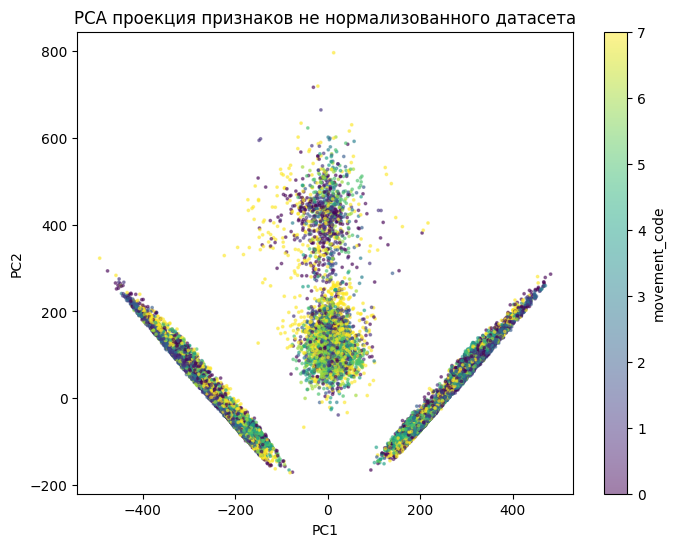

In [63]:
def plot_pca(X_vis, y_vis, normalized=False):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_vis)

    print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=y_vis,
        s=3,
        alpha=0.5
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    if normalized:
        plt.title("PCA проекция признаков нормализованного датасета")
    else:
        plt.title("PCA проекция признаков не нормализованного датасета")
    plt.colorbar(scatter, label="movement_code")
    plt.show()

plot_pca(X_vis, y_vis, normalized=False)

Доля объяснённой дисперсии: [0.08547326 0.07447269]


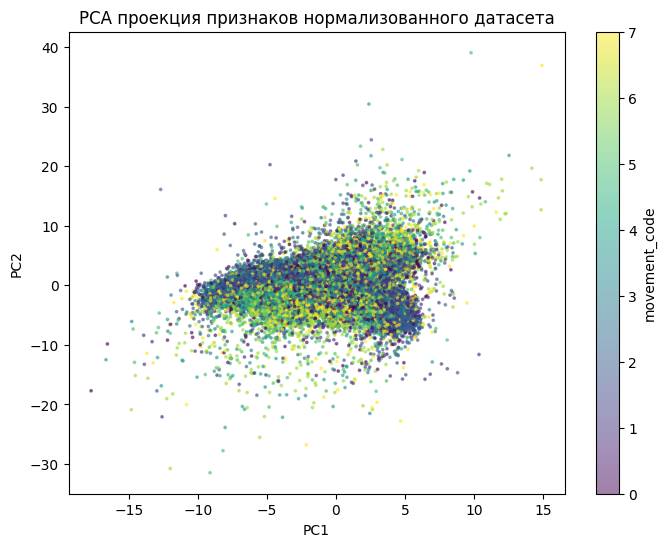

In [64]:
plot_pca(X_scaled, y_vis, normalized=True)

вывод

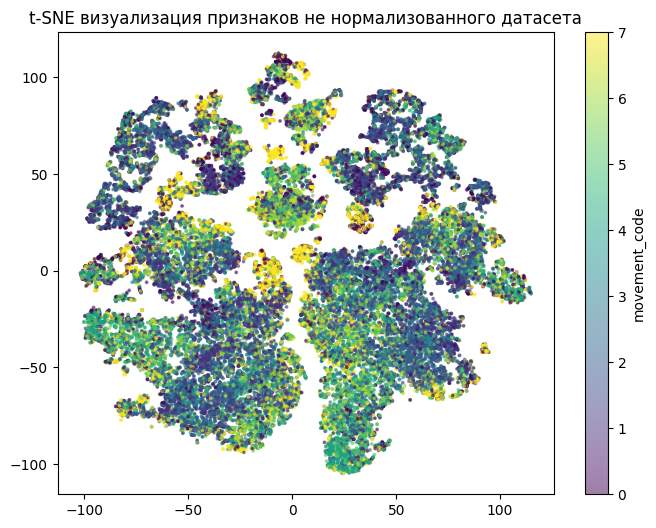

In [65]:
def plot_tsne(X_vis, y_vis, norm=False):
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=42,
    )

    X_tsne = tsne.fit_transform(X_vis)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=y_vis,
        s=3,
        alpha=0.5
    )
    if norm:
        plt.title("t-SNE визуализация признаков нормализованного датасета")
    else:
        plt.title("t-SNE визуализация признаков не нормализованного датасета")
    plt.colorbar(scatter, label="movement_code")
    plt.show()

plot_tsne(X_vis, y_vis, norm=False)

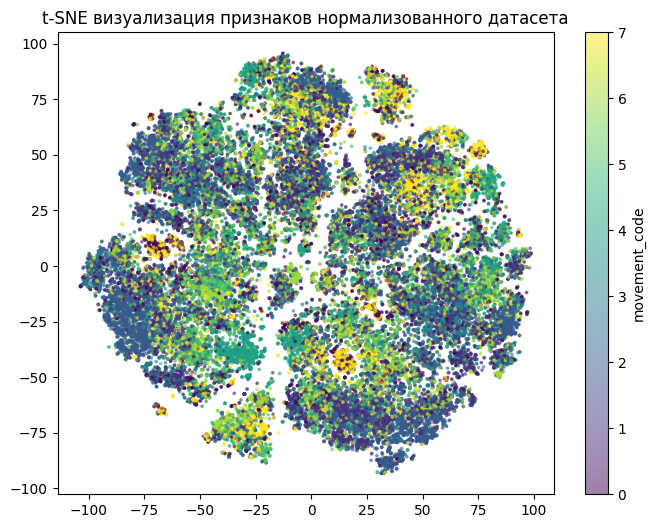

In [66]:
plot_tsne(X_scaled, y_vis, norm=True)

Вывод

7. Подготовка к обучению:
    Split train/test (80/20)

In [72]:
features = [col for col in df_reduced.columns if col not in ['movement_code', 'dataset', 'video', 'frame_time', 'annotator']]
target = 'movement_code'
test_size = 0.2

# Для деревьев (DecisionTree/RandomForest)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    df_tree[features],
    df_tree[target],
    test_size=test_size,
    random_state=42,
    stratify=df_tree[target]
)

# Для SVM/LogReg/NaiveBayes
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    df_scaled[features],
    df_scaled[target],
    test_size=test_size,
    random_state=42,
    stratify=df_scaled[target]
)

print("Размер обучающей выборки:", X_train_tree.shape)
print("Размер тестовой выборки:", X_test_tree.shape)

Размер обучающей выборки: (580517, 163)
Размер тестовой выборки: (145130, 163)


# 3. Построение и тестирование моделей

1. Модели многоклассовой классификации:
    - Logistic Regression (использовали в статье)
    - SVM (использовали в статье)
    - Random Forest (использовали в статье)
    - Decision Tree
    - Naive Bayes 

Для модели Naive Bayes нужна нормальность в данных. В нашем датасете все признаки имеют отличное от нормального распределение. Вероятно модель покажет низкие метрики и как следствие плохие результаты

Настройка GridSearchCV

In [ ]:
cv = 5
scoring = 'roc_auc'
n_jobs = -1

# --- Decision Tree ---

param_tree = {
    'max_depth': [5, 7, 10],
    'min_samples_leaf': [4, 8, 16],
    'max_features': [5, 10],
    'criterion': ['gini']
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_tree,
    scoring=scoring,
    cv=cv,
    n_jobs=n_jobs
)
grid_tree.fit(X_train_tree, y_train_tree)

print("Лучшие параметры SVC:", grid_tree.best_params_)
print("Лучший ROC-AUC:", round(grid_tree.best_score_, 3))

d:\0_moydadir\MII_lab_10_train_model\project\venv3.12\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Лучшие параметры SVC: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1}
Лучший ROC-AUC: nan


In [ ]:
# --- Random Forest ---
param_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [6, 10, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 4, 8],
    'criterion': ['gini']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_rf,
    scoring=scoring,
    cv=3,
    n_jobs=n_jobs
)
grid_rf.fit(X_train_tree, y_train_tree)

print("Лучшие параметры Random Forest:", grid_rf.best_params_)
print("Лучший ROC-AUC:", round(grid_rf.best_score_, 3))

KeyboardInterrupt: 

In [75]:
# --- Gaussian Naive Bayes ---
param_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_nb = GridSearchCV(
    GaussianNB(),
    param_grid=param_nb,
    scoring=scoring,
    cv=cv,
    n_jobs=n_jobs
)
grid_nb.fit(X_train_scaled, y_train_scaled)

print("Лучшие параметры Gaussian Naive Bayes:", grid_nb.best_params_)
print("Лучший ROC-AUC:", round(grid_nb.best_score_, 3))

d:\0_moydadir\MII_lab_10_train_model\project\venv3.12\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Лучшие параметры Gaussian Naive Bayes: {'var_smoothing': 1e-09}
Лучший ROC-AUC: nan


In [ ]:
# --- SVM ---
param_svm = {
    'C': [0.1, 1]
}

grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=param_svm,
    scoring=scoring,
    cv=cv,
    n_jobs=n_jobs
)
grid_svm.fit(X_train_scaled, y_train_scaled)

print("Лучшие параметры SVC:", grid_svm.best_params_)
print("Лучший ROC-AUC:", round(grid_svm.best_score_, 3))

In [76]:
# --- Logistic Regression ---
param_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}

grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_lr,
    scoring=scoring,
    cv=cv,
    n_jobs=n_jobs
)
grid_logreg.fit(X_train_scaled, y_train_scaled)

print("Лучшие параметры Logistic Regression:", grid_logreg.best_params_)
print("Лучший ROC-AUC:", round(grid_logreg.best_score_, 3))

d:\0_moydadir\MII_lab_10_train_model\project\venv3.12\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
2 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "d:\0_moydadir\MII_lab_10_train_model\project\venv3.12\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\0_moydadir\MII_lab_10_train_model\project\venv3.12\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\0_moydadir\MII_lab_10_t

Лучшие параметры Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Лучший ROC-AUC: nan


Сбор и оценка лучших моделей

In [ ]:
best_models = {
    "Decision Tree": grid_tree.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "Naive Bayes": grid_nb.best_estimator_,
    "SVM": grid_svm.best_estimator_,
    "Logistic Regression": grid_logreg.best_estimator_
}

train_test_data = {
    "Decision Tree": (X_train_tree, X_test_tree, y_train_tree, y_test_tree),
    "Random Forest": (X_train_tree, X_test_tree, y_train_tree, y_test_tree),
    "Naive Bayes": (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled),
    "SVM": (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled),
    "Logistic Regression": (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
}

results = []

for name, model in best_models.items():
    X_tr, X_te, y_tr, y_te = train_test_data[name]
    
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='weighted')
    rec = recall_score(y_te, y_pred, average='weighted')
    f1 = f1_score(y_te, y_pred, average='weighted')
    # auc = roc_auc_score(y_te, y_prob, multi_class='ovo', average='weighted')
    
    results.append({
        "Модель": name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3),
        # "ROC-AUC": round(auc, 3)
    })

results_df = pd.DataFrame(results)
print(results_df)

                Модель  Accuracy  Precision  Recall     F1
0  Logistic Regression     0.376      0.379   0.376  0.354


Вывод

Вывод

2. Обучение

Вывод

3. Метрики оценки:
    - Accuracy, Precision, Recall, F1-score (по классам).
    - Confusion matrix.
    - ROC/PR-кривые для многоклассовой задачи.
    - Сравнение времени предсказания и использования памяти.

Вывод

4. Реализация предсказаний на видео с рекордера (для LR или выбранной модели)

Вывод

5. Анализ ошибок:
    Выявление шагов с наибольшей путаницей (например, 2.1 vs 5.2). (взято из статьи)

6. Выводы:
    - Оптимальная модель по точности/скорости/ресурсам.
    - Возможные улучшения (дополнительные признаки, расширение dataset).